# Finger Sign Classification
A multiclass classification of images containing 6 kinds of finger signs.

## 1. Importing required libraries

In [2]:
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

## 2. Preparing Training & Testing datasets

Reading Training & Test data

In [3]:
train_h5 = h5py.File('Signs_Data_Training.h5','r')
test_h5 = h5py.File('Signs_Data_Testing.h5','r')

print(train_h5.keys())
print(test_h5.keys())

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>
<KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>


Creating tesnors of data

In [4]:
train_x = torch.Tensor(train_h5['train_set_x'])
train_y = torch.Tensor(train_h5['train_set_y'])
test_x = torch.Tensor(test_h5['test_set_x'])
test_y = torch.Tensor(test_h5['test_set_y'])

print(train_x.shape, train_y.shape,test_x.shape,test_y.shape)

torch.Size([1080, 64, 64, 3]) torch.Size([1080]) torch.Size([120, 64, 64, 3]) torch.Size([120])


Normalizing images

In [5]:
train_x /=255
test_x /=255

Sample view of training set.

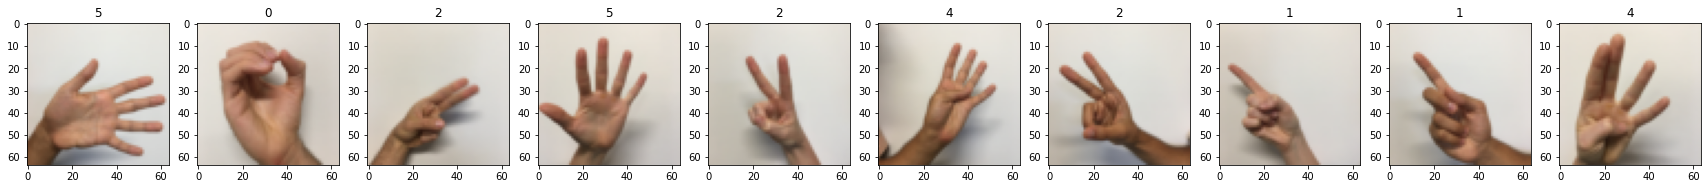

In [6]:
fig,ax = plt.subplots(1,10, figsize=(30,3))

for i in range(10):
    ax[i].imshow(train_x[i])
    ax[i].title.set_text(int(train_y[i]))

In [7]:
m_train,h,w,c = train_x.shape
m_test,h,w,c = test_x.shape

Checking & moving, if CUDA(GPU) is available.

In [11]:
if torch.cuda.is_available():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device, 'will be used.')
    
    train_x = train_x.to(device)
    train_y = train_y.to(device)
    test_x = test_x.to(device)
    test_y = test_y.to(device)

cuda will be used.


## 3. Defining Model

In [130]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,8,4,padding=2)
        self.pool1 = nn.MaxPool2d(8,8)
        self.conv2 = nn.Conv2d(8,16,2,padding=1)
        self.pool2 = nn.MaxPool2d(4,4)
        self.fc3 = nn.Linear(16*2*2,6)
        self.initialize()
    
    def forward(self, X):
        out = F.relu(self.conv1(X.view(-1,c,h,w)))
        out = self.pool1(out)
        out = F.relu(self.conv2(out))
        out = self.pool2(out)
        out = self.fc3(out.view(-1,16*2*2))
        return out
    
    def initialize(self):
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

In [138]:
torch.manual_seed(1)
classifier = Model().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
losses = []

## 4. Training Model
Loop to train model, can rerun this stub with a changed number to train more

In [139]:
for i in range(1000):
    y_h = classifier(train_x)
    classifier.zero_grad()
    loss = loss_func(y_h,train_y.long())
    loss.backward()
    optimizer.step()
    losses.append(loss)
    if i%100==99:
        print('Epoch:{}, loss:{}'.format(i,loss))

Epoch:99, loss:1.467128038406372
Epoch:199, loss:0.8199259042739868
Epoch:299, loss:0.5631185173988342
Epoch:399, loss:0.3978594243526459
Epoch:499, loss:0.2887161374092102
Epoch:599, loss:0.21357770264148712
Epoch:699, loss:0.1563674658536911
Epoch:799, loss:0.11444510519504547
Epoch:899, loss:0.08314407616853714
Epoch:999, loss:0.05946876481175423


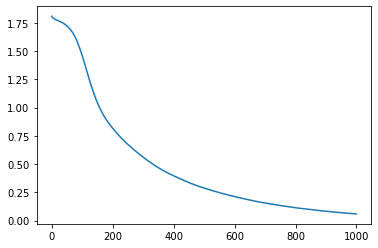

In [140]:
plt.plot(losses)

## 5. Checking how model performed

In [141]:
comp = y_h.max(dim=1).indices == train_y.int()
comp = comp.int()
right_count = comp.sum()
train_acc = right_count/m_train
print('Predicted {} out of {}, training accuracy:{}'.format(right_count,m_train,train_acc))

Predicted 1075 out of 1080, training accuracy:0.9953703284263611


In [142]:
out_test = classifier(test_x)
comp = out_test.max(dim=1).indices == test_y.int()
comp = comp.int()
right_count = comp.sum()
test_acc = right_count/m_test
print('Predicted {} out of {}, testing accuracy:{}'.format(right_count,m_test,test_acc))

Predicted 107 out of 120, testing accuracy:0.8916667103767395
